In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [3]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


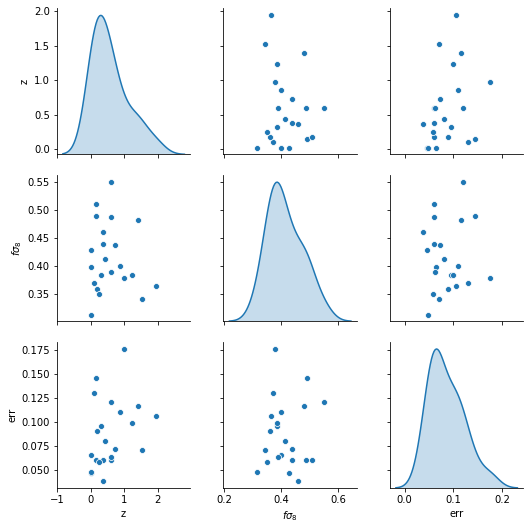

In [4]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [5]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [6]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [7]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [8]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [10]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# batch_size = 4
batch_size = 1
input_z = Input(shape = (1,))
epochs = 20

In [12]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/20
17/17 [==============================] - 0s 6ms/step - loss: 0.0412 - val_loss: 0.0194
Epoch 2/20
17/17 [==============================] - 0s 1ms/step - loss: 0.0200 - val_loss: 0.0152
Epoch 3/20
17/17 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0098
Epoch 4/20
17/17 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 5/20
17/17 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 7/20
17/17 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0015
Epoch 8/20
17/17 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 9/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 10/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 11/20
17/17 [

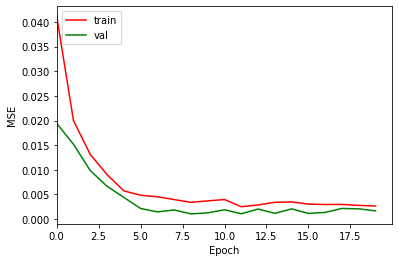

In [13]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)


In [14]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
# print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 0.0009567601955495775 0.0024885754100978374 mil epochs
# 0.0010785672347992659 0.0010806184727698565 500 epochs
# 0.0020020001102238894 0.0008378626080229878 100e
# 0.0021847975440323353 0.0009035465191118419 50e
# 0.002703879727050662 0.0013360671000555158 20e

0.002514042891561985 0.0010535807814449072


In [15]:
pred = neural_model.predict(z_test)
pred

array([[0.43863797, 0.06770638],
       [0.45666373, 0.09063782],
       [0.43801165, 0.08876909],
       [0.42282778, 0.09137493],
       [0.39619812, 0.10525219]], dtype=float32)

In [16]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [17]:
ranz = np.random.uniform(0, 2, size=1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


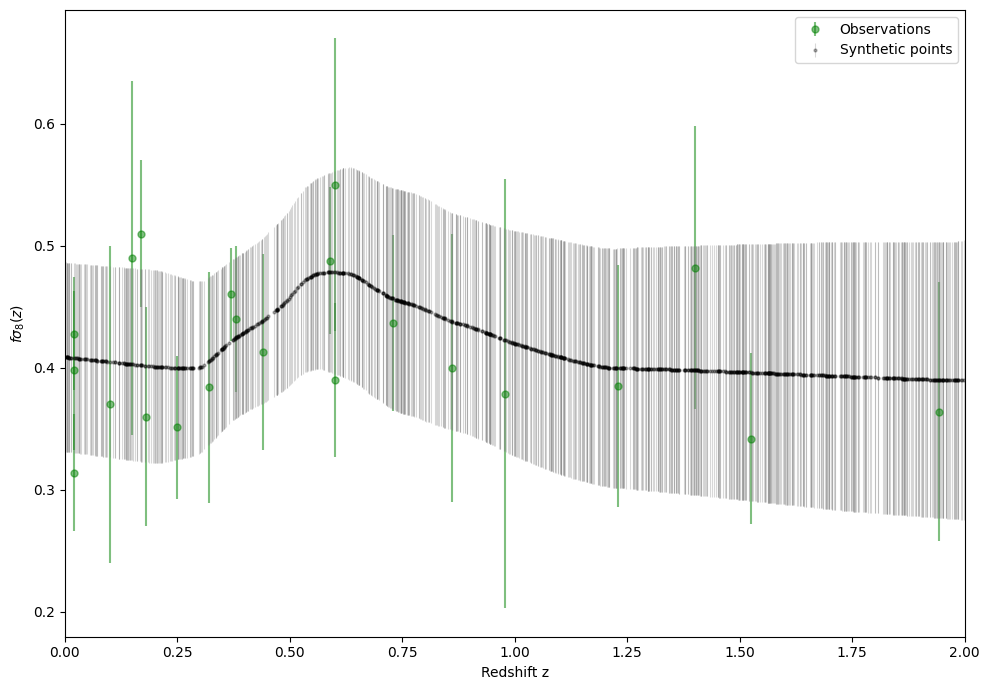

In [18]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',)
plt.xlabel("Redshift z")
plt.ylabel("$f\sigma_8(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend(loc='upper right')
# plt.legend()
# plt.savefig("synthetic_fs8_20.png")

In [19]:
from functools import partial
# Cosmological constants
Om = 0.27
# variance network
s8 = 0.8

In [20]:
def Ezlcdm(a):
    return np.sqrt(Om*(1/a)**3 + 1 - Om)

def RHSquared_a_lcdm(a):
        return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def integrate(fn, lower_bound, upper_array):
    r = np.zeros(len(upper_array))
    print(np.shape(r))
    for i in range(len(upper_array)):
#         r[i] = upper_array[i]
        r[i] = intg.quad(fn, lower_bound, upper_array[i])
    return r

def growth(z):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    try:
        r = integrate(GrowthIntegrand_a, 1e-7, af)
    except:
        r = integrate(GrowthIntegrand_a, 1e-7, (af,))
    gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr
    


# returns the growth factor as a function of redshift
def GrowthIntegrand_a(a):
    return 1./(RHSquared_a_lcdm(a)*a*a)**(1.5)


def fs8(z):
    return -s8*(1+z)*derivative(growth, z, dx=1e-6, n=3)/growth(0)

# def Hlcdm(a, H0=73.24):
#     z = 1./a-1
#     return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

In [21]:
# z = np.linspace(0, 2, 100)
# fs8(z)
# # af = 1./(1.+z)
# # af

In [22]:
# z = np.linspace(0, 2, 100)
# plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

# plt.plot(z, fs8(z), label='$\Lambda CDM$', c='b')
# plt.xlabel("Redshift z")
# plt.ylabel("$f\sigma_8(z)$")
# plt.xlim(0, 2)
# plt.tight_layout()
# plt.legend()

# plt.savefig("Syntheticfs8.png",dpi=800)

In [23]:
# pred_random.shape, r.shape

In [24]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [25]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)

# np.savetxt("annfs850_.dat",mookHz, delimiter=" ")

In [26]:
mookHz

array([[0.43888199, 0.44576624, 0.06384333],
       [1.82160087, 0.36458391, 0.08919398],
       [0.23251123, 0.41351247, 0.06944286],
       [1.49039082, 0.3829959 , 0.09053697],
       [1.78285563, 0.36647931, 0.08984751],
       [1.69082387, 0.37161705, 0.09018546],
       [0.39302758, 0.43313497, 0.06395028],
       [0.47465264, 0.45852673, 0.06269793],
       [1.32848216, 0.39218765, 0.09082099],
       [1.44658484, 0.38548288, 0.09061378],
       [0.46299959, 0.45459026, 0.06309818],
       [1.17831898, 0.40080854, 0.09106646],
       [1.77253491, 0.36698613, 0.09002589],
       [1.45610726, 0.38494217, 0.0905971 ],
       [1.2417282 , 0.39711279, 0.09097316],
       [1.05883554, 0.41369966, 0.08903808],
       [0.60602161, 0.4737066 , 0.07890072],
       [0.45786095, 0.45248467, 0.06316917],
       [0.9195094 , 0.43177366, 0.09137463],
       [1.76357227, 0.36748707, 0.09005778],
       [0.03291727, 0.41255641, 0.07557654],
       [0.67188853, 0.46324527, 0.0851711 ],
       [1.

In [27]:
predy_reduced[:,1]

array([0.06384333, 0.08919398, 0.06944286, 0.09053697, 0.08984751,
       0.09018546, 0.06395028, 0.06269793, 0.09082099, 0.09061378,
       0.06309818, 0.09106646, 0.09002589, 0.0905971 , 0.09097316,
       0.08903808, 0.07890072, 0.06316917, 0.09137463, 0.09005778,
       0.07557654, 0.0851711 , 0.09040777, 0.0910663 , 0.09306264,
       0.09023483, 0.09005199, 0.08915829, 0.06347807, 0.07356955,
       0.0716304 , 0.09084035, 0.09038176, 0.09059367, 0.07147332,
       0.0891113 , 0.06801464, 0.09095951, 0.08903365, 0.09025168,
       0.07189358, 0.09014132, 0.08892172, 0.0716304 , 0.09036363,
       0.08913997, 0.07538364, 0.06767043, 0.06270893, 0.07736931],
      dtype=float32)

In [28]:
error  = predy_reduced[:,1]**2
error

array([0.00407597, 0.00795557, 0.00482231, 0.00819694, 0.00807258,
       0.00813342, 0.00408964, 0.00393103, 0.00824845, 0.00821086,
       0.00398138, 0.0082931 , 0.00810466, 0.00820783, 0.00827612,
       0.00792778, 0.00622532, 0.00399034, 0.00834932, 0.0081104 ,
       0.00571181, 0.00725412, 0.00817356, 0.00829307, 0.00866065,
       0.00814233, 0.00810936, 0.0079492 , 0.00402947, 0.00541248,
       0.00513091, 0.00825197, 0.00816886, 0.00820721, 0.00510844,
       0.00794082, 0.00462599, 0.00827363, 0.00792699, 0.00814536,
       0.00516869, 0.00812546, 0.00790707, 0.00513091, 0.00816559,
       0.00794593, 0.00568269, 0.00457929, 0.00393241, 0.00598601],
      dtype=float32)

In [29]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50_.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

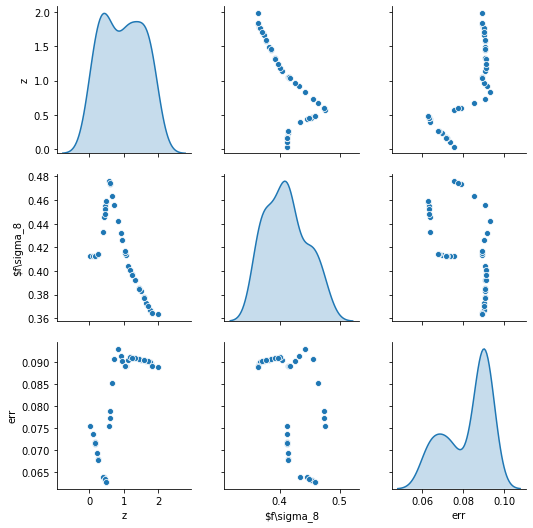

In [30]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake_.png")

In [31]:
from astroNN.nn.layers import MCDropout

In [32]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((17, 1), (17, 1), (5, 1), (5, 1))

In [33]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100, 50, 50])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/2000
5/5 [==============================] - 0s 26ms/step - loss: 0.1068 - val_loss: 0.0901
Epoch 2/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0888 - val_loss: 0.0812
Epoch 3/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0907 - val_loss: 0.0753
Epoch 4/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0853 - val_loss: 0.0755
Epoch 5/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0824 - val_loss: 0.0622
Epoch 6/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0701 - val_loss: 0.0654
Epoch 7/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0684 - val_loss: 0.0675
Epoch 8/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0636 - val_loss: 0.0591
Epoch 9/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0621 - val_loss: 0.0581
Epoch 10/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0585 - val_loss: 0.0521
Epoch 11/2000
5/5 

Epoch 84/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0176 - val_loss: 0.0122
Epoch 85/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0098
Epoch 86/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - val_loss: 0.0080
Epoch 87/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 88/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0121
Epoch 89/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0207 - val_loss: 0.0077
Epoch 90/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0123
Epoch 91/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0047
Epoch 92/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 93/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0106 - val_loss: 0.0134
Epoch 94/2

Epoch 248/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0041
Epoch 249/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0014
Epoch 250/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 251/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0035
Epoch 252/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0074
Epoch 253/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 254/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 255/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0037
Epoch 256/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 257/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0043


Epoch 330/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 331/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 332/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 333/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 334/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 335/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 336/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 337/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 338/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 339/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0046


Epoch 412/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 413/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0068
Epoch 414/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0018
Epoch 415/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 416/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 417/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 418/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 419/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 420/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 421/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0018


Epoch 494/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0063
Epoch 495/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 496/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 497/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 498/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 499/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 500/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 501/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 502/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 503/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0031


Epoch 576/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 577/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 578/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 579/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0056
Epoch 580/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0052
Epoch 581/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 582/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 583/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 584/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 585/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0032


Epoch 658/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 659/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 660/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 661/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 662/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 663/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 664/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 665/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 666/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 667/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0026


Epoch 740/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 741/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 742/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 743/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 744/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 745/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 9.0649e-04
Epoch 746/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 747/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 748/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 749/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0

Epoch 822/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 823/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 824/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 825/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 826/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 827/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 828/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0065
Epoch 829/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 830/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 831/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0018


Epoch 904/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 905/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 906/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 907/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 908/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 909/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 910/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 911/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 912/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 913/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0049


Epoch 986/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0057
Epoch 987/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 988/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 989/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 990/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 991/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 992/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 993/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 994/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 995/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0035


5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 1149/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 1150/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 1151/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 1152/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 1153/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 1154/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 1155/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 1156/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 1157/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 1311/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 1312/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 1313/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1314/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 1315/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 1316/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 1317/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 1318/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 1319/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 1473/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 1474/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 1475/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 1476/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 1477/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 1478/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 1479/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 1480/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 1481/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 1635/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 1636/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1637/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 1638/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 1639/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 1640/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 1641/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 1642/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 1643/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 

5/5 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 1797/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 1798/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 1799/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 1800/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 1801/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 1802/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 1803/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 1804/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 1805/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 1959/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 1960/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 1961/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 1962/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1963/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 1964/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 1965/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 1966/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 1967/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 

In [34]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [35]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.028754234590171096, 0.013966649395816473)

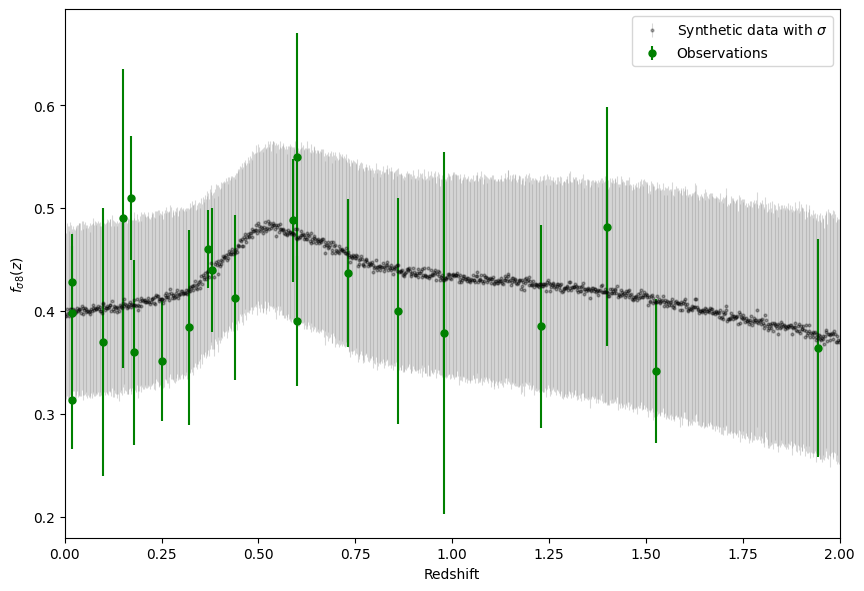

In [36]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0,2)
plt.xlabel('Redshift')
plt.ylabel('$f_{\sigma8}(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
# plt.savefig('fs8_dropout.png', dpi=100)

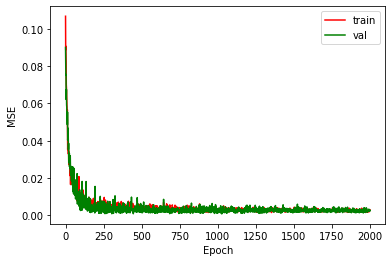

In [37]:
plt.plot(model2_train.history['loss'], color='r')
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig('lossfs8dropout.png', dpi=100)

In [38]:
mookdpfs8 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("annfs850dropout.dat",mookdpfs8, delimiter=" ")

In [39]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("annfs8_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

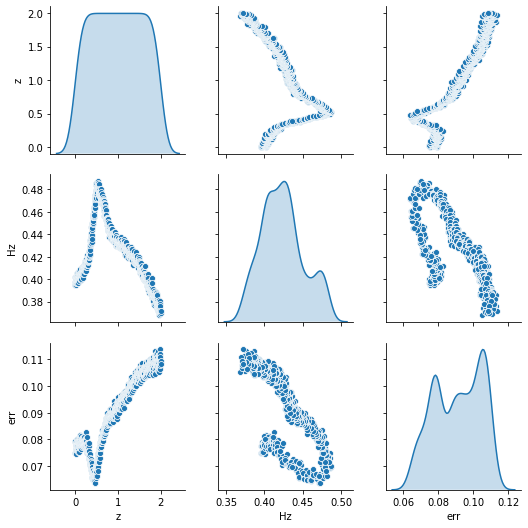

In [40]:
dfMook = pd.DataFrame(mookdpfs8, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50fs8dmookdropout.png")